# Setup

In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np
import cv2
from functools import partial

In [3]:
%aimport am_registration.rotation
%aimport am_registration.utils
%aimport am_registration.clustering
%aimport am_registration.visual
%aimport am_registration.image_processing
from am_registration.rotation import *
from am_registration.utils import *
from am_registration.clustering import *
from am_registration.visual import *
from am_registration.image_processing import *

In [4]:
import logging
if not logging.getLogger('am-reg').handlers:
    init_logger()
logger = logging.getLogger('am-reg')

# Load Data

In [20]:
source_path = Path('data/AMs_6Aug2019/source/7-real_well-2-F/source.tiff')
mask_path = Path('data/AMs_6Aug2019/pseudo_tiles_stitched/7-real_well-2-F/mask.tiff')

In [21]:
source = cv2.imread(str(source_path), cv2.IMREAD_GRAYSCALE)
source.shape

(9298, 15416)

In [22]:
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
# mask = mask / 255
mask.shape

(4632, 7680)

In [23]:
h, w = source.shape
mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
mask.shape

(9298, 15416)

In [24]:
acq_grid_shape = (60, 100)

In [106]:
image = mask.copy().astype(np.uint8)
min_max(image)

(0, 255)

In [107]:
row_offset, col_offset, patch_size = 0, 14500, 1000
cut = partial(cut_patch, y_offset=row_offset, x_offset=col_offset, patch=patch_size)

# Rotate Mask

In [28]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

100

In [29]:
best_angle = optimal_mask_rotation(image, target_axis, angle_range=2, angle_step=0.1)
best_angle

2019-08-27 15:44:46,278 - am-reg - INFO - Target axis: 1, best angle: -0.500, best proj 0.576


-0.49999999999999867

In [108]:
image = rotate_image(image, best_angle)

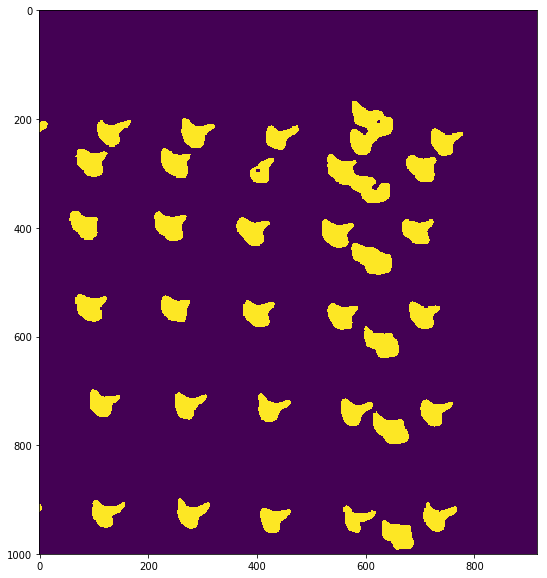

In [109]:
plot_image(cut(image))

# Clean Mask and Find Centers

In [110]:
image = erode_dilate(image)
am_centers = find_am_centers(image)

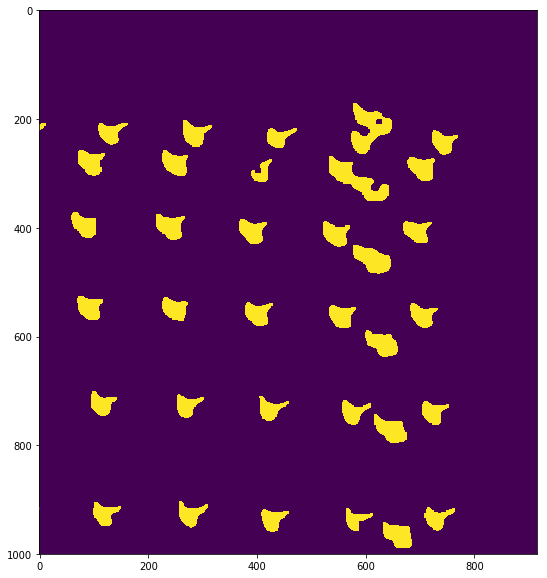

In [111]:
plot_image(cut(image))

In [112]:
len(am_centers)

5843

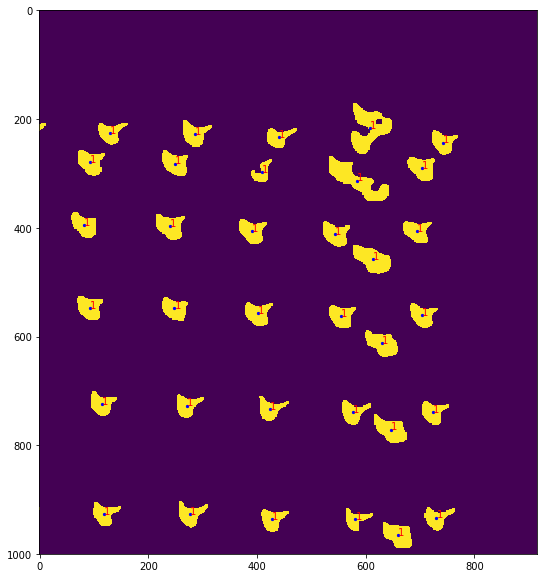

In [113]:
# shifted_centers, shifted_indices = \
#     shift_center_coords(am_centers, np.ones(am_centers.shape[0], dtype=int),
#                         row_offset, col_offset, patch_size)
labels = np.ones(am_centers.shape[0], dtype=int)
plot_am_labels(cut(image), am_centers, labels, row_offset, col_offset, patch_size)

# Cluster Centers

In [114]:
am_centers.shape

(5843, 2)

In [115]:
target_axis = 0  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

60

In [116]:
y_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2019-08-27 16:04:20,991 - am-reg - INFO - Clustering (5843,) array into 60 clusters


In [117]:
y_axis_coords = am_centers[:,target_axis]

In [118]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

100

In [119]:
x_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2019-08-27 16:04:22,199 - am-reg - INFO - Clustering (5843,) array into 100 clusters


In [120]:
x_axis_coords = am_centers[:,target_axis]

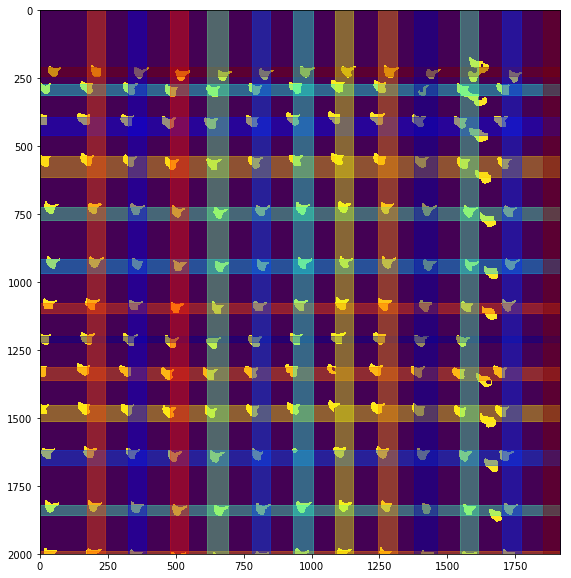

In [121]:
patch = cut_patch(image, row_offset, col_offset-1000, 2000)
# patch = cut(image)
ax = plot_image(patch)
plot_labels(ax, patch, 0, y_axis_coords, y_labels, set(y_labels))
plot_labels(ax, patch, 1, x_axis_coords, x_labels, set(x_labels))

In [122]:
acq_y_grid = convert_labels_to_grid(y_axis_coords, y_labels, set(y_labels))
acq_x_grid = convert_labels_to_grid(x_axis_coords, x_labels, set(x_labels))
acq_indices = convert_grid_to_indices(acq_y_grid, acq_x_grid, acq_grid_shape[1])

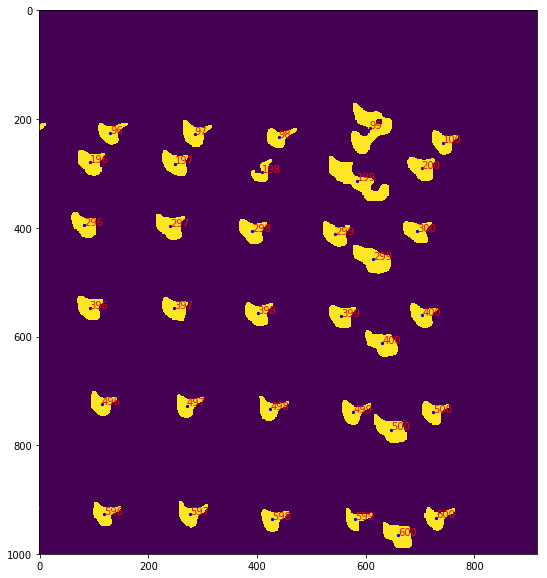

In [123]:
plot_am_labels(cut(image), am_centers, acq_indices, row_offset, col_offset, patch_size)

# Rotate Image and AM Centers Back

In [124]:
best_angle

-0.49999999999999867

In [125]:
image = rotate_image(image, -best_angle)

In [126]:
# plot_image(cut_patch(image))

In [127]:
am_centers = rotate_am_centers(am_centers, -best_angle, image.shape)
# am_centers

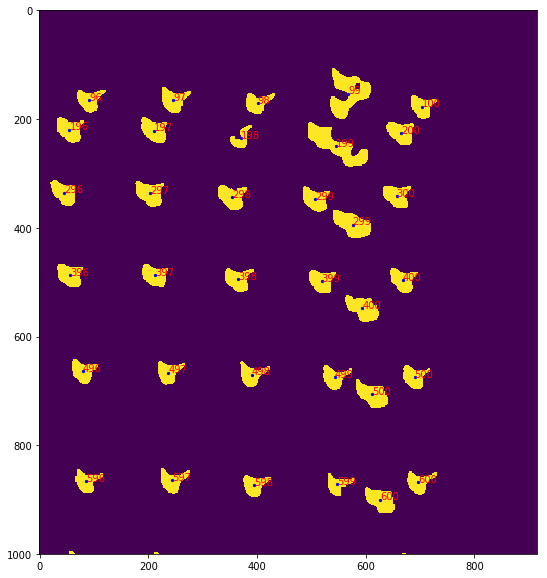

In [128]:
plot_am_labels(cut(image), am_centers, acq_indices, row_offset, col_offset, patch_size)

# Fill Mask with Acqusition Indices

In [129]:
acq_indices.shape

(5843,)

In [130]:
# plot_image(cut_patch(image))

In [131]:
am_n, markers = cv2.connectedComponents(image.copy().astype(np.uint8))
# patch = cut_patch(markers)
# plot_image(cut_patch(markers))

In [132]:
markers_coo = coo_matrix(markers)

marker_acq_index_mapping = np.zeros_like(markers_coo.data)
for (c_row, c_col), acq_idx in zip(am_centers, acq_indices):
    marker = markers[c_row, c_col]
    marker_acq_index_mapping[marker] = acq_idx
    
markers_coo.data = marker_acq_index_mapping[markers_coo.data]
# markers = markers_coo.toarray()

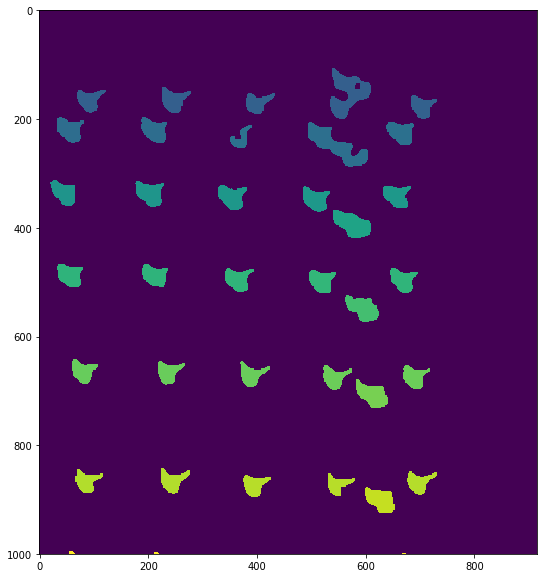

In [133]:
img = markers.copy()
img[img == 0] = -255  # to make the first row with small marker values visible
plot_image(cut(img))

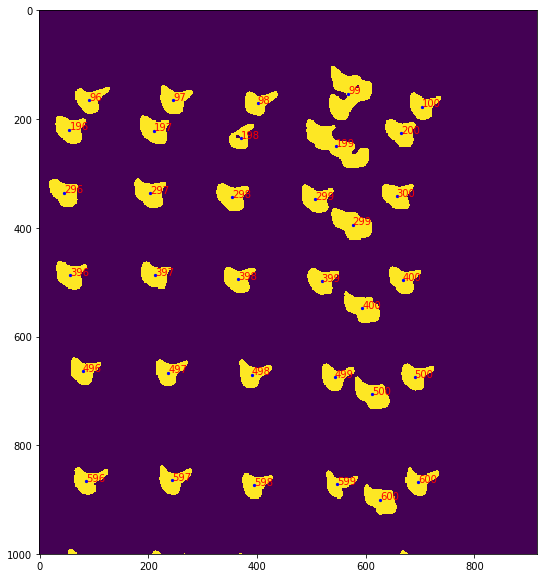

In [145]:
plot_am_labels(cut(mask), am_centers, acq_indices, row_offset, col_offset, patch_size)

In [146]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(source, cmap='gray')
# ax.imshow(img > 0, alpha=0.5)
# plt.savefig('/tmp/image.png', dpi=600, bbox_inches='tight')

In [148]:
plot_am_labels(mask, am_centers, acq_indices)
plt.savefig(
    '/tmp/image.png',
#     dpi=600,
    bbox_inches='tight',
)
plt.close()

# Convert and Save Results

In [136]:
import operator

In [137]:
%%time
am_x_y_coords = []
for acq_idx in range(1, operator.mul(*acq_grid_shape) + 1):
    pixel_inds = (markers_coo.data == acq_idx).nonzero()[0]
    ys = markers_coo.row[pixel_inds]
    xs = markers_coo.col[pixel_inds]
    am_x_y_coords.append([xs, ys])

CPU times: user 26.7 s, sys: 73.5 ms, total: 26.8 s
Wall time: 26.8 s


In [138]:
np.save('marks_mask.npy', am_x_y_coords)

In [139]:
am_x_y_coords = np.load('marks_mask.npy')

In [140]:
am_x_y_coords[0]

array([array([185, 186, 187, ..., 204, 205, 206], dtype=int32),
       array([269, 269, 269, ..., 311, 311, 311], dtype=int32)],
      dtype=object)

In [141]:
m = np.zeros_like(markers)
for idx, (xs, ys) in enumerate(am_x_y_coords, 1):
    m[ys, xs] = idx

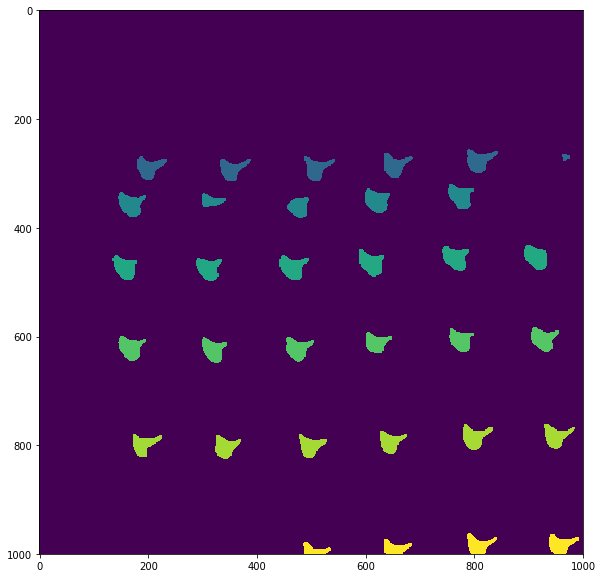

In [142]:
m[m == 0] = -255
plot_image(cut_patch(m))

In [335]:
# a = np.load('data/test_AM_image/marksMask.npy')
# a.shape
# xs, ys, = a[0]
# xs.shape, ys.shape
# xs